# 1.0 Purpose
The purpose of this notebook is to use Embedding for a Natural Language Processing (NLP) task with TensorFlow on the Text Generation from Eminem.

# 2.0 Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import time
print(tf.__version__)

2.5.0


## Helper Functions

### decode_review

In [ ]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])



### get_training_metrics

In [ ]:
def get_training_metrics(history):
  
  # This is needed depending on if you used the pretrained model or you trained it yourself
  if not isinstance(history, pd.core.frame.DataFrame):
    history = history.history
  
  acc = history['binary_accuracy']
  val_acc = history['val_binary_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']

  return acc, val_acc, loss, val_loss

### plot_train_eval

In [ ]:
def plot_train_eval(history,name='',parameters='',optimizer_name='',loss='',accuracy_metric='',epochs='',vocab_size='',embedding_dim='',max_length='',trunc_type='',oov_tok=''):
  acc, val_acc, loss_values, val_loss = get_training_metrics(history)

  acc_plot = pd.DataFrame({"training accuracy":acc, "evaluation accuracy":val_acc})
  acc_plot = sns.lineplot(data=acc_plot)
  acc_plot.set_title(f'training vs evaluation accuracy: {name} \n # parameters={parameters} \n optimizer_name={optimizer_name} \n loss={loss} \n accuracy_metric={accuracy_metric} \n epochs={epochs} \n vocab_size={vocab_size} \n embedding_dim={embedding_dim} \n max_length={max_length} \n trunc_type={trunc_type} \n oov_tok={oov_tok}')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel(accuracy_metric)
  plt.savefig(f'{name} - train_acc_vs_eval_acc.jpg',bbox_inches='tight')
  plt.show()


  print("")

  loss_plot = pd.DataFrame({"training loss":loss_values, "evaluation loss":val_loss})
  loss_plot = sns.lineplot(data=loss_plot)
  loss_plot.set_title(f'training vs evaluation loss: {name} \n # parameters={parameters} \n optimizer_name={optimizer_name}  \n loss={loss} \naccuracy_metric={accuracy_metric} \n epochs={epochs} \n vocab_size={vocab_size} \n embedding_dim={embedding_dim} \n max_length={max_length} \n trunc_type={trunc_type} \n oov_tok={oov_tok}')
  loss_plot.set_xlabel('epoch')
  loss_plot.set_ylabel(loss)
  plt.savefig(f'{name} - train_loss_vs_eval_loss.jpg',bbox_inches='tight')
  plt.show()

### model_picker

In [ ]:
def model_picker(vocab_size=100,embedding_dim=16,input_length=100,model_name='model1',rnn_units=1024,max_sequence_len=100):

  if model_name=='model1':
    model = tf.keras.Sequential([
                                tf.keras.layers.Embedding(vocab_size, 100, input_length=max_sequence_len-1),
                                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
                                tf.keras.layers.Dense(vocab_size,activation='softmax')
    ])
    model_description=f'Embedding(vocab_size={vocab_size}, \n embedding_dim={embedding_dim}, \n input_length={max_length}), \n GRU({rnn_units},return_sequence=True,stateful=True,recurrent_initializer=glorot_uniform) \n Flatten, \n Dense({vocab_size},softmax)'
  return model,model_description

### loss_picker

In [ ]:
def loss_picker(loss_name='categorical_crossentropy'):

  if loss_name=='categorical_crossentropy':
    loss='categorical_crossentropy'
  return loss

# 3.0 Import Eminem Lyrics dataset from Kaggle

## 3.0.1 [Find your Kaggle Account and click the **Create New API Token** to download the json file](https://www.kaggle.com/stevensmiley/account?isEditing=False)

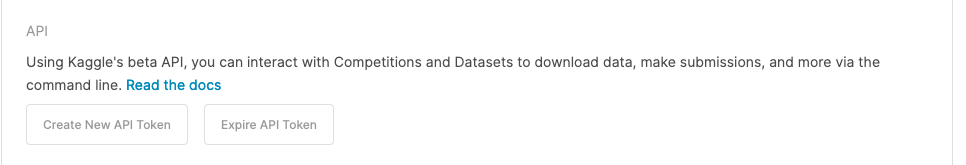

## 3.0.2 **Upload** kaggle.json file

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


## 3.0.3 Pick the **kaggle.json** file from your Kaggle download

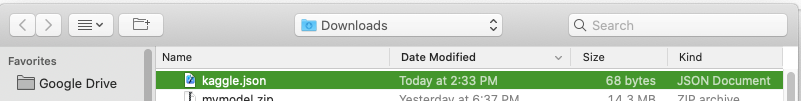

## 3.0.4 install kaggle with pip

In [ ]:
! pip install -q kaggle

## 3.0.5 create kaggle directory

In [ ]:
! mkdir ~/.kaggle 

## 3.0.6 copy the kaggle.json file to the kaggle directory

In [ ]:
! cp kaggle.json ~/.kaggle/

## 3.0.7 Set 600 permissions to a kaggle.json file so you (owner) has full read and write access to the file, while no other user can access the file.

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

## 3.0.8 List the kaggle datasets

In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-06-14 06:30:31           7447  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           4514  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1527  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-06-09 15:58:24           2210  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Wo

## 3.0.9 download the dataset

In [ ]:
!kaggle datasets download -d thaddeussegura/eminem-lyrics-from-all-albums

  0% 0.00/782k [00:00<?, ?B/s]
100% 782k/782k [00:00<00:00, 53.6MB/s]


## 3.0.9 Create **train** directory

In [ ]:
! mkdir train

## 3.0.10 Create **test** directory

In [ ]:
! mkdir test

## 3.0.11 **new_dir** 
helper function for making directories

In [ ]:
def new_dir(path):
  try:
    os.mkdir(path)
  except:
    print(f'Already have: {path}')
    pass

## 3.0.12 get_training_metrics
helper function for getting history metrics

In [ ]:
def get_training_metrics(history):
  
  # This is needed depending on if you used the pretrained model or you trained it yourself
  if not isinstance(history, pd.core.frame.DataFrame):
    history = history.history
  
  acc = history['binary_accuracy']
  val_acc = history['val_binary_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']

  return acc, val_acc, loss, val_loss

## 3.0.13 plot_train_eval
helper function for plotting history metrics

In [ ]:
def plot_train_eval(history,name='',parameters='',num_images_per_epoch_train='',num_images_per_epoch_val='',batch_size=''):
  acc, val_acc, loss, val_loss = get_training_metrics(history)

  acc_plot = pd.DataFrame({"training accuracy":acc, "evaluation accuracy":val_acc})
  acc_plot = sns.lineplot(data=acc_plot)
  acc_plot.set_title(f'training vs evaluation accuracy: {name} \n # parameters={parameters} \n num_images_per_epoch_train={num_images_per_epoch_train} \n num_images_per_epoch_val={num_images_per_epoch_val} \n batch_size={batch_size}')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel('binary_crossentropy')
  plt.savefig(f'{name} - train_acc_vs_eval_acc.jpg',bbox_inches='tight')
  plt.show()


  print("")

  loss_plot = pd.DataFrame({"training loss":loss, "evaluation loss":val_loss})
  loss_plot = sns.lineplot(data=loss_plot)
  loss_plot.set_title(f'training vs evaluation loss: {name} \n # parameters={parameters} \n num_images_per_epoch_train={num_images_per_epoch_train} \n num_images_per_epoch_val={num_images_per_epoch_val} \n batch_size={batch_size}')
  loss_plot.set_xlabel('epoch')
  loss_plot.set_ylabel('loss')
  plt.savefig(f'{name} - train_loss_vs_eval_loss.jpg',bbox_inches='tight')
  plt.show()






In [ ]:
cols=['filename','model_name',
      'optimizer',
      'loss',
      'accuracy_metric',
      'batch_size','img_size',
      'steps_per_epoch','epochs','validation_steps',
      'num_images_per_epoch_train','num_images_per_epoch_val',
      'data_augmentation',
      'F1_score_dog','F1_score_cat',
      'Precision_dog','Precision_cat',
      'Recall_dog','Recall_cat',
      'misclassified_dogs','misclassified_cats']
df_metrics=pd.DataFrame(columns=cols)
df_metrics

,filename,model_name,optimizer,loss,accuracy_metric,batch_size,img_size,steps_per_epoch,epochs,validation_steps,num_images_per_epoch_train,num_images_per_epoch_val,data_augmentation,F1_score_dog,F1_score_cat,Precision_dog,Precision_cat,Recall_dog,Recall_cat,misclassified_dogs,misclassified_cats


In [ ]:
!unzip eminem-lyrics-from-all-albums.zip

Archive:  eminem-lyrics-from-all-albums.zip
  inflating: eminem_lyrics/ALL_eminem.txt  
  inflating: eminem_lyrics/eminem_25tolife.txt  
  inflating: eminem_lyrics/eminem_313.txt  
  inflating: eminem_lyrics/eminem_3am.txt  
  inflating: eminem_lyrics/eminem_97bonnieandclyde.txt  
  inflating: eminem_lyrics/eminem_almostfamous.txt  
  inflating: eminem_lyrics/eminem_amityville.txt  
  inflating: eminem_lyrics/eminem_arose.txt  
  inflating: eminem_lyrics/eminem_asshole.txt  
  inflating: eminem_lyrics/eminem_asslikethat.txt  
  inflating: eminem_lyrics/eminem_astheworldturns.txt  
  inflating: eminem_lyrics/eminem_baby.txt  
  inflating: eminem_lyrics/eminem_backstabber.txt  
  inflating: eminem_lyrics/eminem_badguy.txt  
  inflating: eminem_lyrics/eminem_badhusband.txt  
  inflating: eminem_lyrics/eminem_badmeetsevil.txt  
  inflating: eminem_lyrics/eminem_bagpipesfrombaghdad.txt  
  inflating: eminem_lyrics/eminem_ballinuncontrollably.txt  
  inflating: eminem_lyrics/eminem_beautiful

In [ ]:
f=open('/content/eminem_lyrics/ALL_eminem.txt','r')
text=f.read()
f.close()

In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

Look, I was gonna go easy on you not to hurt your feelings
But I'm only going to get this one chance
(Six minutes, six minutes)
Something's wrong, I can feel it
(Six minutes, six minutes, Slim Shady, you're on)
Just a feeling I've got
Like something'


In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

109 unique characters


In [ ]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [ ]:
len(sorted(set(text)))

109

In [ ]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '$' :   4,
  '%' :   5,
  '&' :   6,
  "'" :   7,
  '(' :   8,
  ')' :   9,
  '*' :  10,
  '+' :  11,
  ',' :  12,
  '-' :  13,
  '.' :  14,
  '/' :  15,
  '0' :  16,
  '1' :  17,
  '2' :  18,
  '3' :  19,
  ...
}


In [ ]:
repr(text[:20])

"'Look, I was gonna go'"

In [ ]:
text_as_int[:20]

array([40, 72, 72, 68, 12,  1, 37,  1, 80, 58, 76,  1, 64, 72, 71, 71, 58,
        1, 64, 72])

In [ ]:
# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'Look, I was g' ---- characters mapped to int ---- > [40 72 72 68 12  1 37  1 80 58 76  1 64]


In [ ]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

L
o
o
k
,


In [ ]:
len(text_as_int)

925005

In [ ]:
[w.numpy() for w in char_dataset.take(5)]

[40, 72, 72, 68, 12]

In [ ]:
[idx2char[w.numpy()] for w in char_dataset.take(12)]

['L', 'o', 'o', 'k', ',', ' ', 'I', ' ', 'w', 'a', 's', ' ']

In [ ]:
seq_length

100

In [ ]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

"Look, I was gonna go easy on you not to hurt your feelings\nBut I'm only going to get this one chance\n"
"(Six minutes, six minutes)\nSomething's wrong, I can feel it\n(Six minutes, six minutes, Slim Shady, yo"
"u're on)\nJust a feeling I've got\nLike something's about to happen\nBut I don't know what\nIf that means"
", what I think it means, we're in trouble\nBig trouble. And if he is as bananas as you say\nI'm not tak"
"ing any chances\nYou are just what the doc ordered\n\nI'm beginning to feel like a Rap God, Rap God\nAll "


In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [ ]:
dummy=''
for i,(item,other) in enumerate(dataset.take(1)):
  print('INPUT_TEXT')
  print(''.join(idx2char[item.numpy()]))
  print('TARGET_TEXT')
  print(''.join(idx2char[other.numpy()]))
  dummy=''.join(idx2char[item.numpy()])
print(i)

INPUT_TEXT
Look, I was gonna go easy on you not to hurt your feelings
But I'm only going to get this one chance
TARGET_TEXT
ook, I was gonna go easy on you not to hurt your feelings
But I'm only going to get this one chance

0


In [ ]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  "Look, I was gonna go easy on you not to hurt your feelings\nBut I'm only going to get this one chance"
Target data: "ook, I was gonna go easy on you not to hurt your feelings\nBut I'm only going to get this one chance\n"


In [ ]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 40 ('L')
  expected output: 72 ('o')
Step    1
  input: 72 ('o')
  expected output: 72 ('o')
Step    2
  input: 72 ('o')
  expected output: 68 ('k')
Step    3
  input: 68 ('k')
  expected output: 12 (',')
Step    4
  input: 12 (',')
  expected output: 1 (' ')


In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [ ]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

# 4.1 model1

In [ ]:
model1 = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model1(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 109) # (batch_size, sequence_length, vocab_size)


In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           27904     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 109)           111725    
Total params: 4,077,933
Trainable params: 4,077,933
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [ ]:
sampled_indices

array([105,  63,  98,  63,  40,  95,  55,  80,  55,  84,  55,  17,   4,
        39,  65,  66,  15,  49,  38,  17,  57,  15,  30,   4,  26,  68,
        90,  69,  10,  32,  17,  97,  84,  91,  47,  42,   8,  60,  80,
         8,  58,  37,  28,  25,   7,  27,  39,  91,   7,  27,  61,  33,
        62,  54,  90,  80,  55,  97,  43,  22,  27, 104,  54,  66,  66,
        73,   4,  93,  49,  16,  89,   3,  26,   4,  14,   3, 102,  71,
        50,  81,  28,  71,  10,  94,  90,  13,   1,  18,  18,  75, 108,
        84,  61,  21,  96,  29,  45,  99,  68,   2])

In [ ]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 'appreciate my art\n\nAnd it just breaks my heart to look at all the pain I caused\nBut what am I gonna '

Next Char Predictions: 
 '“fúfLí[w[{[1$Khi/UJ1`/B$:kál*D1ö{âSN(cw(aI?9\';Kâ\';dEeZáw[öO6;’Ziip$çU0à":$."—nVx?n*éá- 22r′{d5óAQük!'


In [ ]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 109)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.6908293


In [ ]:
model1.compile(optimizer='adam', loss=loss)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
EPOCHS=100

In [ ]:
history = model1.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/100
143/143 [==============================] - 8s 41ms/step - loss: 2.8738
Epoch 2/100
143/143 [==============================] - 6s 41ms/step - loss: 2.1265
Epoch 3/100
143/143 [==============================] - 6s 41ms/step - loss: 1.8742
Epoch 4/100
143/143 [==============================] - 7s 41ms/step - loss: 1.7171
Epoch 5/100
143/143 [==============================] - 6s 41ms/step - loss: 1.6117
Epoch 6/100
143/143 [==============================] - 6s 40ms/step - loss: 1.5298
Epoch 7/100
143/143 [==============================] - 6s 40ms/step - loss: 1.4636
Epoch 8/100
143/143 [==============================] - 6s 40ms/step - loss: 1.4045
Epoch 9/100
143/143 [==============================] - 6s 40ms/step - loss: 1.3511
Epoch 10/100
143/143 [==============================] - 6s 40ms/step - loss: 1.2987
Epoch 11/100
143/143 [==============================] - 6s 40ms/step - loss: 1.2467
Epoch 12/100
143/143 [==============================] - 6s 40ms/step - loss: 1.1947
E

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_100'

# 4.2 model2

In [ ]:
model2 = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model2.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model2.build(tf.TensorShape([1, None]))

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            27904     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 109)            111725    
Total params: 4,077,933
Trainable params: 4,077,933
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [ ]:
print(generate_text(model2, start_string=u"Steven's rap song starts like this: "))

Steven's rap song starts like this: kay back to Mileway from Renoeherey
Feels like I'm rollin' Melong Viskes, closs Keuckers, blood get low the hair
Wherever we to have said
"3 this is Hullo and came at me any
"How many-veinging niggas and atsent, let's start attack on some man twice some cractors
Alium AIDSLike a day from these problems gay to the siders
Tired for my favorite (ya), 2 de thirty people says "Dum!

[R R Eminem - debass finally advent violently Bull I was so stab half a hill wits the loud
Keep their hoppin' inker the dreams left of them
Introlling I get popped out and fire she killint drop it out, wishin' the water
I don't want to a wond-was seething

I'm gone you cut check, but can I get to a secord samal's sceetin

You pept me to think though
You can't sleep willimatine alike you're infinored
There she gon' have to followered
Promising nowher hearted
So plosit and gow on tof live a dire

I never called have y Binger bown
Possible platter back only knows
So welcome mysel

# 4.3 model3

## Advanced: Customized Training

The above training procedure is simple, but does not give you much control.

So now that you've seen how to run the model manually let's unpack the training loop, and implement it ourselves. This gives a starting point if, for example, to implement _curriculum learning_ to help stabilize the model's open-loop output.

We will use `tf.GradientTape` to track the gradients.

The procedure works as follows:

* First, initialize the RNN state. We do this by calling the `tf.keras.Model.reset_states` method.

* Next, iterate over the dataset (batch by batch) and calculate the *predictions* associated with each.

* Open a `tf.GradientTape`, and calculate the predictions and loss in that context.

* Calculate the gradients of the loss with respect to the model variables using the `tf.GradientTape.grads` method.

* Finally, take a step downwards by using the optimizer's `tf.train.Optimizer.apply_gradients` method.



In [ ]:
model3 = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [ ]:
optimizer = tf.keras.optimizers.Adam()

In [ ]:
@tf.function
def train_step(inp, target):
  with tf.GradientTape() as tape:
    predictions = model3(inp)
    loss = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(
            target, predictions, from_logits=True))
  grads = tape.gradient(loss, model3.trainable_variables)
  optimizer.apply_gradients(zip(grads, model3.trainable_variables))

  return loss

In [ ]:
# Training step
EPOCHS = 300

for epoch in range(EPOCHS):
  start = time.time()

  # initializing the hidden state at the start of every epoch
  # initally hidden is None
  hidden = model3.reset_states()

  for (batch_n, (inp, target)) in enumerate(dataset):
    loss = train_step(inp, target)

    if batch_n % 100 == 0:
      template = 'Epoch {} Batch {} Loss {}'
      print(template.format(epoch+1, batch_n, loss))

  # saving (checkpoint) the model every 5 epochs
  if (epoch + 1) % 5 == 0:
    model3.save_weights(checkpoint_prefix.format(epoch=epoch))

  print ('Epoch {} Loss {:.4f}'.format(epoch+1, loss))
  print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

model3.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 4.691030502319336
Epoch 1 Batch 100 Loss 2.419247627258301
Epoch 1 Loss 2.3299
Time taken for 1 epoch 7.298924922943115 sec

Epoch 2 Batch 0 Loss 2.309969425201416
Epoch 2 Batch 100 Loss 2.0268666744232178
Epoch 2 Loss 1.9750
Time taken for 1 epoch 6.292811870574951 sec

Epoch 3 Batch 0 Loss 1.962658405303955
Epoch 3 Batch 100 Loss 1.8578009605407715
Epoch 3 Loss 1.7915
Time taken for 1 epoch 6.294831991195679 sec

Epoch 4 Batch 0 Loss 1.7691415548324585
Epoch 4 Batch 100 Loss 1.6520618200302124
Epoch 4 Loss 1.6715
Time taken for 1 epoch 6.292683124542236 sec

Epoch 5 Batch 0 Loss 1.6208549737930298
Epoch 5 Batch 100 Loss 1.5431021451950073
Epoch 5 Loss 1.5593
Time taken for 1 epoch 6.322150468826294 sec

Epoch 6 Batch 0 Loss 1.5555797815322876
Epoch 6 Batch 100 Loss 1.5412497520446777
Epoch 6 Loss 1.5085
Time taken for 1 epoch 6.302106857299805 sec

Epoch 7 Batch 0 Loss 1.417521357536316
Epoch 7 Batch 100 Loss 1.4486624002456665
Epoch 7 Loss 1.4698
Time taken for 

# 4.4 model4

In [ ]:
model4 = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model4.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model4.build(tf.TensorShape([1, None]))

In [ ]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [ ]:
print(generate_text(model4, start_string=u"Steven's rap song starts like this: "))

Steven's rap song starts like this: I Mh I take don't day probably would picane heall hit dart
With racell in Carver cell late
welling tenica and me bodes afirs too hiloush it now, y't be if I can't hoin' agay
Bouts, otties? I ain't nevee through to but make but I'm on, gaty fuckin harnce
Better love tripped 'es I'm about, bout have lit

're she's plays?"
OJ would' mo, imp's gavil, 'em sig crown the patipse 1 snoe man, firsed if I'm along it baby
When I'd stratlyns the but I'm
I'm brain it's that's why I give a plan stchott aun all you canat you're and the redact?
And I'm anter I feel, the never show shows and spindo

My much
Who mad, put how rinder it raid ear ofe's back the Zell it ball you bar need terrie they cracked ace uh-what's crazy dood-ow puss in a clook to torought I wannable,
Bed evore, Shady, just a smackeds all up go not, but dour bedie's hadd up!
No to spiry)
Shade next! "Who long it love a swoff
Nut Dre (Me) Dead
So for me a strook the end you know youm bood shew.
' ain

# 5.0 Export Models

In [ ]:
!zip -r /content/model1.zip /content/model1

	zip warning: name not matched: /content/model1

zip error: Nothing to do! (try: zip -r /content/model1.zip . -i /content/model1)


In [ ]:
!zip -r /content/model2.zip /content/model2

	zip warning: name not matched: /content/model2

zip error: Nothing to do! (try: zip -r /content/model2.zip . -i /content/model2)


In [ ]:
!zip -r /content/model3.zip /content/model3

	zip warning: name not matched: /content/model3

zip error: Nothing to do! (try: zip -r /content/model3.zip . -i /content/model3)


In [ ]:
!zip -r /content/model4.zip /content/model4 

	zip warning: name not matched: /content/model4

zip error: Nothing to do! (try: zip -r /content/model4.zip . -i /content/model4)


# Install **rclone**
This is so you can save your checkpoints weights to your actual google drive for restoration.

In [ ]:
! curl https://rclone.org/install.sh | sudo bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4491  100  4491    0     0   3578      0  0:00:01  0:00:01 --:--:--  3578
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    15  100    15    0     0     14      0  0:00:01  0:00:01 --:--:--    14
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.8M  100 13.8M    0     0  3941k      0  0:00:03  0:00:03 --:--:-- 3940k
Archive:  rclone-current-linux-amd64.zip
   creating: tmp_unzip_dir_for_rclone/rclone-v1.55.1-linux-amd64/
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.55.1-linux-amd64/README.txt  [text]  
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.55.1-linux-amd64/rclone.1  [text]  
  inflating:

You want to create a remote configuration with rclone.  Use the default recommendations.

In [ ]:
!rclone config

2021/06/14 12:44:33 NOTICE: Config file "/root/.config/rclone/rclone.conf" not found - using defaults
No remotes found - make a new one
n) New remote
s) Set configuration password
q) Quit config
n/s/q> n
name> remote
Type of storage to configure.
Enter a string value. Press Enter for the default ("").
Choose a number from below, or type in your own value
 1 / 1Fichier
   \ "fichier"
 2 / Alias for an existing remote
   \ "alias"
 3 / Amazon Drive
   \ "amazon cloud drive"
 4 / Amazon S3 Compliant Storage Providers including AWS, Alibaba, Ceph, Digital Ocean, Dreamhost, IBM COS, Minio, and Tencent COS
   \ "s3"
 5 / Backblaze B2
   \ "b2"
 6 / Box
   \ "box"
 7 / Cache a remote
   \ "cache"
 8 / Citrix Sharefile
   \ "sharefile"
 9 / Compress a remote
   \ "compress"
10 / Dropbox
   \ "dropbox"
11 / Encrypt/Decrypt a remote
   \ "crypt"
12 / Enterprise File Fabric
   \ "filefabric"
13 / FTP Connection
   \ "ftp"
14 / Google Cloud Storage (this is not Google Drive)
   \ "google cloud sto

# Copy Content to **Google Drive** with **rclone**
Try to copy exisiting weights to a future directory to ensure rclone is configured right

This line tests the ability to copy known weights to a directory on you **Google Drive** with **rclone**

In [ ]:
!rclone copy "/content/"  remote:"/Colab_Notebooks/GitHub/TensorFlow_Examples/Basics/Wk8/content"